# Human Activity Recognition with Smartphones

This notebook is a detailed reproduction of a DATA LIFTOFF Kaggle notebook. I have studied and annotated sections that were initially challenging to understand.

URL: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones


Data was collected from 30 participants wearing (Samsung Galaxy S II) Watches during their daily activities. 

The device is equipped with acclerometer and gyroscope sensors, consistently collecting data approximately every 1.28 seconds. 

The primary goal is to extract comprehensive insights fro, this dataset.

In [1]:
# import kagglehub

# path = kagglehub.dataset_download('uciml/human-activity-recognition-with-smartphones')

# print('path to dataset files', path)

### Reference
1. https://www.kaggle.com/code/morrisb/what-does-your-smartphone-know-about-you
2. https://www.kaggle.com/code/abheeshthmishra/eda-of-human-activity-recognition
3. https://www.kaggle.com/code/fahadmehfoooz/human-activity-recognition-with-neural-networks

### Import Library

In [2]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import matplotlib

# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# To gbm light
from lightgbm import LGBMClassifier

# To measure time
from time import time

# To ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # FutureWarning만 무시
# 혹은 모든 경고 무시: warnings.filterwarnings("ignore")


In [3]:
# Load dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine boths dataframes
'''To distinguish between train and test data'''
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'

'''Coalescing in the row direction.
test data is added to the end of the train data
reset_index() is used to reset the index of the DataFrame(Ignore existing index)
'''
both_df = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)
both_df['subject'] = '#' + both_df['subject'].astype(str) # subject 실험자
# both_df.to_csv('both_df.csv', index = False) #check for data
# Create Label
label = both_df.pop('Activity') # Activity is the target variable

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


### which feature are there?
- We can distinguish the features by name.
- Let's use split to count the number of main names.

[Example]

1. tBodyAcc-mean()-X => it have '-', so extract 'tBodyAcc'
2. angle(tBodyAccMean.gravity) => it has '(' not '-', so extract 'angle')

In [4]:
'''
1. Run repeat statement
2. Counter
3. Converting to DataFrame
4. Sort
'''
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns = {0: 'count'}).sort_values('count', ascending = False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


There mainly are 'acc(acceleration)', 'Gyro(gyroscope)' features. A few 'gravitiy' features are there.

### Check Null value and get dataframe info

In [5]:
print('Null Values in DataFrame: {}\n'.format(both_df.isna().sum().sum())) # 1. one sum() is for each column, 2. another sum() is for all columns
both_df.info()

Null Values in DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


Except from the label and newly created 'Data' and 'subject' features, there is only numerical data.

Fortunately there are missing values.

### How are the labels distributed?

In [6]:
label_counts = label.value_counts()
print(label_counts)

n = label_counts.shape[0] #total count
colormap = matplotlib.colormaps['viridis'] # bring color map 'virdis'
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))] #convert rgb to hex / color map want float value

# create bar chart
data = go.Bar(x = label_counts.index, # name
              y = label_counts, 
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

# create figure with data and layout
fig = go.Figure(data = [data], layout = layout)
iplot(fig)

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64


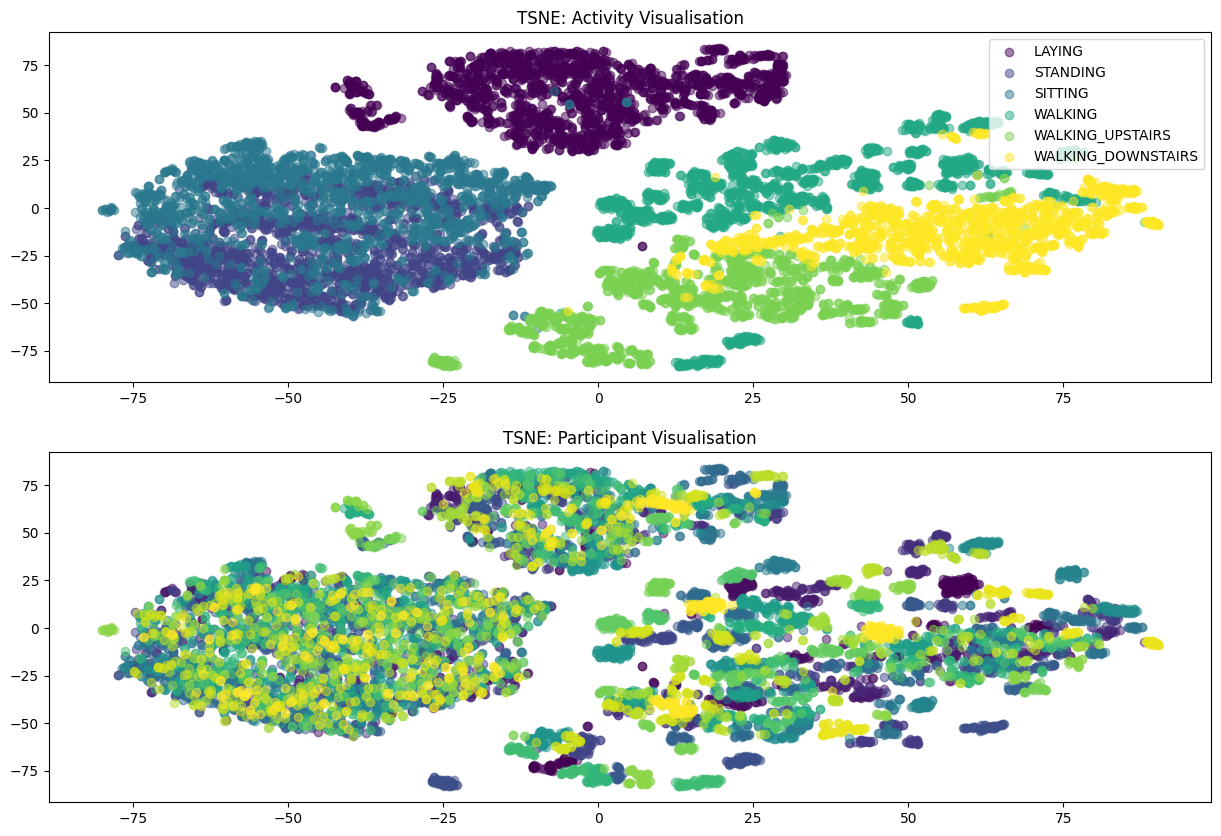

In [7]:
'''
process of data preprocessing, dimensonality reduction, and visualization using t-SNE
'''
# create data

tsne_data = both_df.copy()
# purely for visualiztion (no Data(Train/test), subject)
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components = 0.9, random_state = 3) # minimum number of components to explain 90% of the variance. for speed up(t-SNE)
tsne_data = pca.fit_transform(tsne_data)

# Transfomr data
## t-SNE(t-distributed Stochasitc Neighbor Embedding): non-linear dimensionality reduction technique well-suited for embedding high-demensional data for visulaization in a low-dimensional space of two or three dimensions
tsne = TSNE(random_state = 3) 
tsne_transformed = tsne.fit_transform(tsne_data)

# create subplt
fig, axarr = plt.subplots(2, 1, figsize = (15, 10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = matplotlib.colormaps['viridis']
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# plot each activity - for classification
## label_counts.index: activity name(6개)
for i, group in enumerate(label_counts.index):
    mask = (label == group).values # same column name [true, false, true, false, ...]
    axarr[0].scatter(x = tsne_transformed[mask][:, 0], y = tsne_transformed[mask][:, 1], c = colors[i], alpha = 0.5, label = group)
    axarr[0].set_title('TSNE: Activity Visualisation')
    axarr[0].legend()

# plot subject - for personalization
# get colors
n = subject_data.unique().shape[0]
colormap = matplotlib.colormaps['viridis']
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(subject_data.unique()):
    mask = (subject_data == group).values
    axarr[1].scatter(x = tsne_transformed[mask][:, 0], y=tsne_transformed[mask][:, 1], c = colors[i], alpha = 0.5, label = group)
    
axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()


In plot 1, The activities are mostly separable

In plot 2, Everybody has an unique/separable walking style 

Therefore, the smartphone should be able to detect what your are doing and also who is using the smartphone (if you are moving aroun with it)

since the walking data is separated when compartd to other activities, there is a difference in the way each experimenter walks, so individual characteristics are clearly included

## Test the accuracy to see how the activity data are separated

In [8]:
# split traing testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state = 3)

# create the model
lgbm = LGBMClassifier(n_estimators = 500, random_state = 3, verbose = -1)
lgbm = lgbm.fit(X_train, y_train)

# Test the model
## y_true: actual value, y_pred: predicted_value
score = accuracy_score(y_true = y_test, y_pred = lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))


Accuracy on testset:	0.9643



with a basic untuned LGBM model, the activity of smartphone user can be predicted with an accuracy of 96%.

This is pretty striking regarding six equally distributed labels.

## Test the accuracy to see how the participants data are separated

In [9]:
# Sore the data
data = []

# Interate over each activity
for activity in label_counts.index:
    # Create a dataset
    act_data = both_df[label == activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')

    # Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)

    # Reduce dimensions
    pca = PCA(n_components = 0.9, random_state = 3)
    act_data = pca.fit_transform(act_data)

    # Split training test data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train, X_test, y_train, y_test = train_test_split(act_data, label_encoded, random_state = 3)

    # Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators = 500, random_state = 3, verbose = -1)
    lgbm = lgbm.fit(X_train, y_train)

    score = accuracy_score(y_true = y_test, y_pred = lgbm.predict(X_test))
    print('Accuracy on testset:\t{:.4f}\n'.format(score))
    data.append([activity, score])

Activity: LAYING
Accuracy on testset:	0.6461

Activity: STANDING
Accuracy on testset:	0.5367

Activity: SITTING
Accuracy on testset:	0.5303

Activity: WALKING
Accuracy on testset:	0.9606

Activity: WALKING_UPSTAIRS
Accuracy on testset:	0.9249

Activity: WALKING_DOWNSTAIRS
Accuracy on testset:	0.9148



It seems possible to distinguish what kind of activities the experimenter does. Especially in the walking part, it is possible to distinguish the walking style of 30 different people with 96% accuracy. About 92% of walking upstairs and 91% of waling downstaris. 

What is noteworthy is that the accuracy seems to increase as the participants move.

The accuracy increases when subjects moves

This means each person's unique walkig/movement style

### How long does the smartphone gate data for this accuracy?

In [10]:
'''
Number of columns of 'Data' groupping labels (standing, walking...) and subject_data(#1, #2,...) in both_df
'''
duration_df = (both_df.groupby([label, subject_data])['Data'] # group by activity and subject each. ## label and subject_data's index is used, so it's possible to user groupby
              .count() # count the number of 'Data' in rows
              .reset_index() # reset and make into DataFrame
              .groupby('Activity') # regroup by activity
              .agg({ 'Data': 'mean' }) * 1.28 # After regrouping to 'Activity', the average of the number of 'Data; is obtained and multiplied by 1.28 (1.28 is the average time in seconds for each activity) ## each subject activity's average time
              ).rename(columns = {'Data' : 'Senconds'})
activity_df = pd.DataFrame(data, columns = ['Activity', 'Accuracy']).set_index('Activity')
activity_df.join(duration_df)

,Accuracy,Senconds
Activity,,
LAYING,0.646091,82.944000
STANDING,0.536688,81.322667
SITTING,0.530337,75.818667
WALKING,0.960557,73.472000
WALKING_UPSTAIRS,0.924870,65.877333
WALKING_DOWNSTAIRS,0.914773,59.989333


### Which sensor is more important for classifying participants by walking style?
Simple model generation and analysis are conducted to distinguish the walking style of participations

Use feature_importnace in LGBM to find out which value of feature importance is important

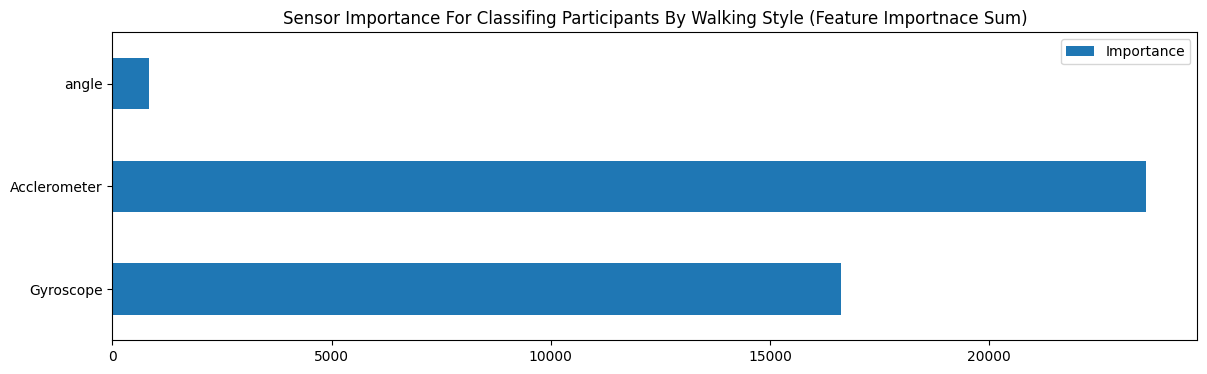

In [11]:
# create dataset
tsne_data = both_df[label == 'WALKING'].copy() # extract only 'WALKING' data, throught the label index
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state = 3)

# Create model
lgbm = LGBMClassifier(n_estimators = 500, random_state = 3, verbose = -1)
lgbm = lgbm.fit(X_train, y_train)

# Get importance
features = both_df.drop(['Data', 'subject'], axis = 1).columns
importances = lgbm.feature_importances_

# Sum importances
data = { 'Gyroscope': 0, 'Acclerometer': 0, 'angle': 0 }
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Acclerometer'] += importance
    if 'angle' in feature: # Add angle column because curios about the importance of other features
        data['angle'] += importance

# create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient = 'index').rename(columns = { 0: 'Importance'})
sensor_df.plot(kind = 'barh', figsize = (14,4), title = 'Sensor Importance For Classifing Participants By Walking Style (Feature Importnace Sum)')
plt.show()

The accelerometer supplies slightly more information. Both sensors(acc, gyroscope) are important for classification and refraining from using both sensors will be a drawback for the quality of the model. so use both columns

### what is feature importance?
Feature importance is a score calculated by combining the number of times each feature was used when the model learned or the information gain obtained when splitting.

This score represents the extend to which that feaure contributed to the predicion (classification), and the higher the score, the greater the effect the fatrue had on the model

### How long does the participants use the staircase
The data has been performed nearly the same environment, depending on the scientific environment.

It's highly likelyfor the participants to have been walking up and down the same number of staircases. 

Let us investigate their activity durations

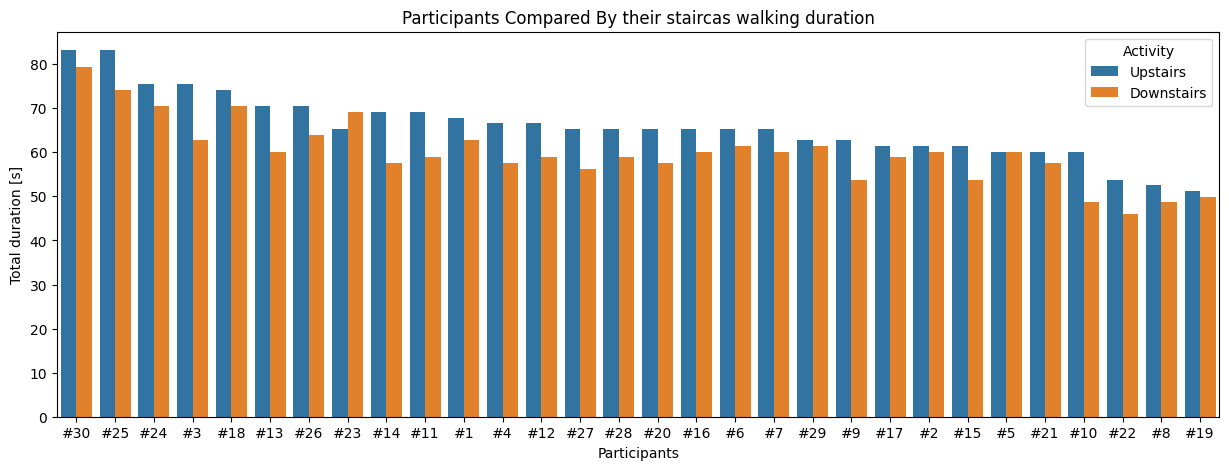

In [12]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (both_df[mask].groupby([label[mask], 'subject'])['Data']).count() * 1.28 #both_df[mask] means only truev value is selected so EX) groupby(['WALKING_UPSTAIRS], 'subject')

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending = False)
plot_data['Activity'] = plot_data['Activity'].map({ 'WALKING_UPSTAIRS': 'Upstairs', 'WALKING_DOWNSTAIRS': 'Downstairs'})

plt.figure(figsize = (15, 5))
sns.barplot(data = plot_data, x = 'subject', y = 'Data', hue = 'Activity')
plt.title('Participants Compared By their staircas walking duration')
plt.xlabel('Participants')
plt.ylabel('Total duration [s]')
plt.show()

Nearly all participants have more data for walking upstairs thatn downstaris. Assuming an equal number of up - and down-walks the participants need longer walking upstairs.

Furthermore the range of the duration is narrow and adjusted to the conditions. A young person being ~50% fast in walking upstairs than an older one is reasonable

=> Considering that the participants' ages range from 19 to 48 years, it is reasonable to infer that younger individuals tend to walk upstairs approximately 50% faster that their older counterparts.

## How much does the up-downstairs ratio vary?

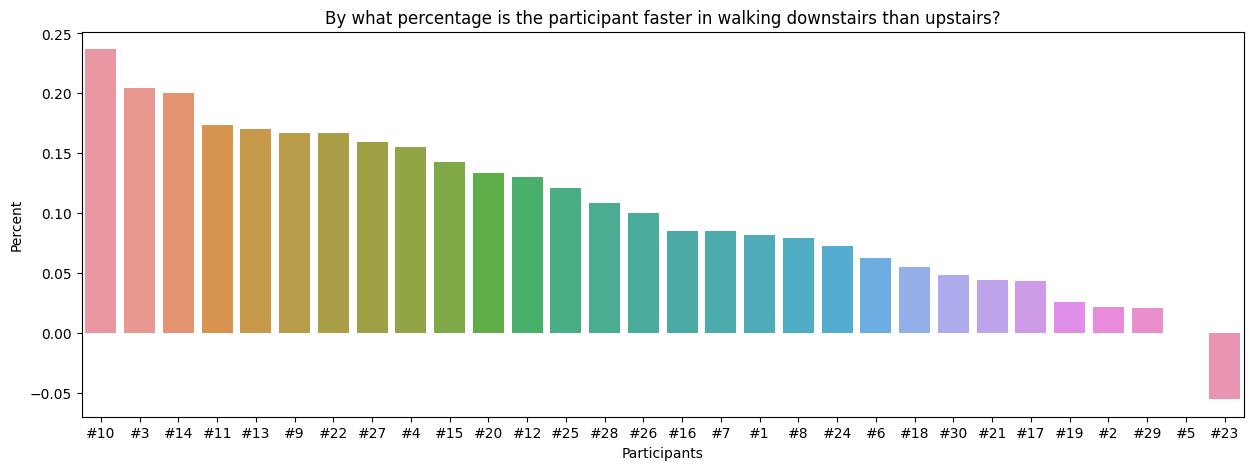

In [13]:
'''
loc: extract the row with the index ex) 'walking_upstaris' and 'walking_downstairs'
-1 is used to calculate the percentage relatively
'''
plt.figure(figsize = (15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending = False)
sns.barplot(x = plot_data.index, y = plot_data)
plt.title('By what percentage is the participant faster in walking downstairs than upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

There is a wide range in between the participants for their ratio of up-/down-walking. 

Since this represents therir physical condition I can imagine a correlation to their age and health (speculative)

## Are there conspicuities in the staircase walking duration distribution?

C:\Users\vivid\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




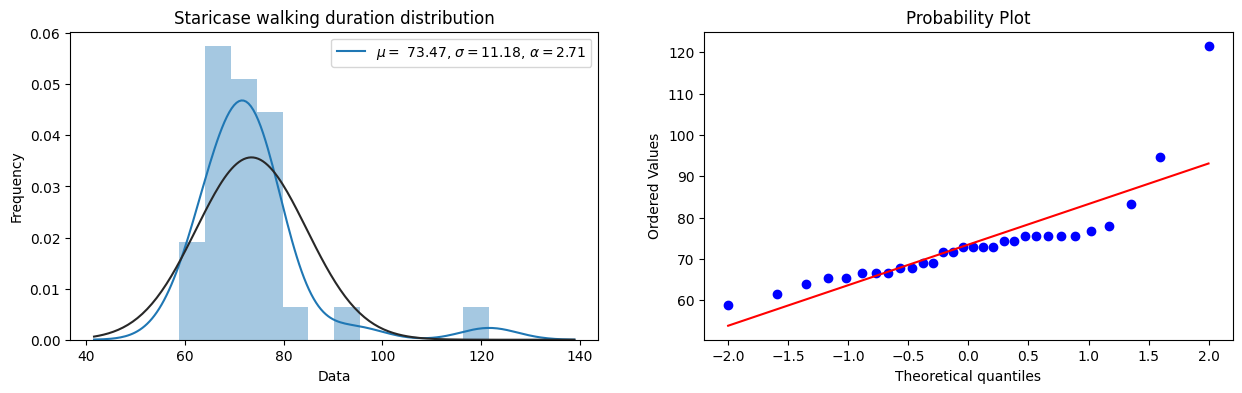

In [36]:
def plotSkew(x):
    (mu, sigma) = norm.fit(x) # scipy.stats.norm.fit(): estimate the parameters of the normal distribution ##정규분포 fit
    alpha = skew(x) # scipy.stats.skew(): skewness of the data ## 왜도계산
    ### skewness: the skewness represents the asymmetry(비대칭) of the distribution, and for a normal distribution, it should ususally be a value close to zero. (0에 가까운 값)

    fig, axarr = plt.subplots(1, 2, figsize = (15, 4))

    # plot label and fit
    sns.distplot(x, fit = norm, ax = axarr[0]) # fit  = norm / axarr: axes(축) numpy array
    axarr[0].legend(['$\mu=$ {:.2f}, $\sigma = ${:.2f}, $\\alpha = ${:.2f}'.format(mu, sigma, alpha)], loc = 'best') # $: LaTex: 수학식 표기
    axarr[0].set_title('Staricase walking duration distribution')
    axarr[0].set_ylabel('Frequency')

    # plot probability plot
    res = probplot(x, plot = axarr[1])
    plt.show()

plotSkew(duration_df)

Many statistical analysis methods are designed based on the assumption that data follows a normal distribution.

If the data meets this assumption, these techniques can be applied without issues, increasing the reliability of the results.

In particular, modeling and many machine learning algorithms or predictive models perform more effectively when the data is assumed to follow a normal distribution. Additionally, detecting and handling outliers becomes more efficient under this assumption.

1. Left Graph: The data appears to follow a distribution close to normal. However, the tails (both the left and right ends) may slightly deviate from a perfect normal distribution.
2. Right Graph (Q-Q Plot): The Q-Q plot is a tool for assessing the normality of data. If the points are positioned close to the red line (represention the theoretical normal distribution), the data can be considered normally distributed. While most points are near the red line, the data at both ends (tails) slightly deviate from the line

### As aspected from most real world data the duration walking on the staircase is normally distributed

### Is there a unique walking style for each participant?

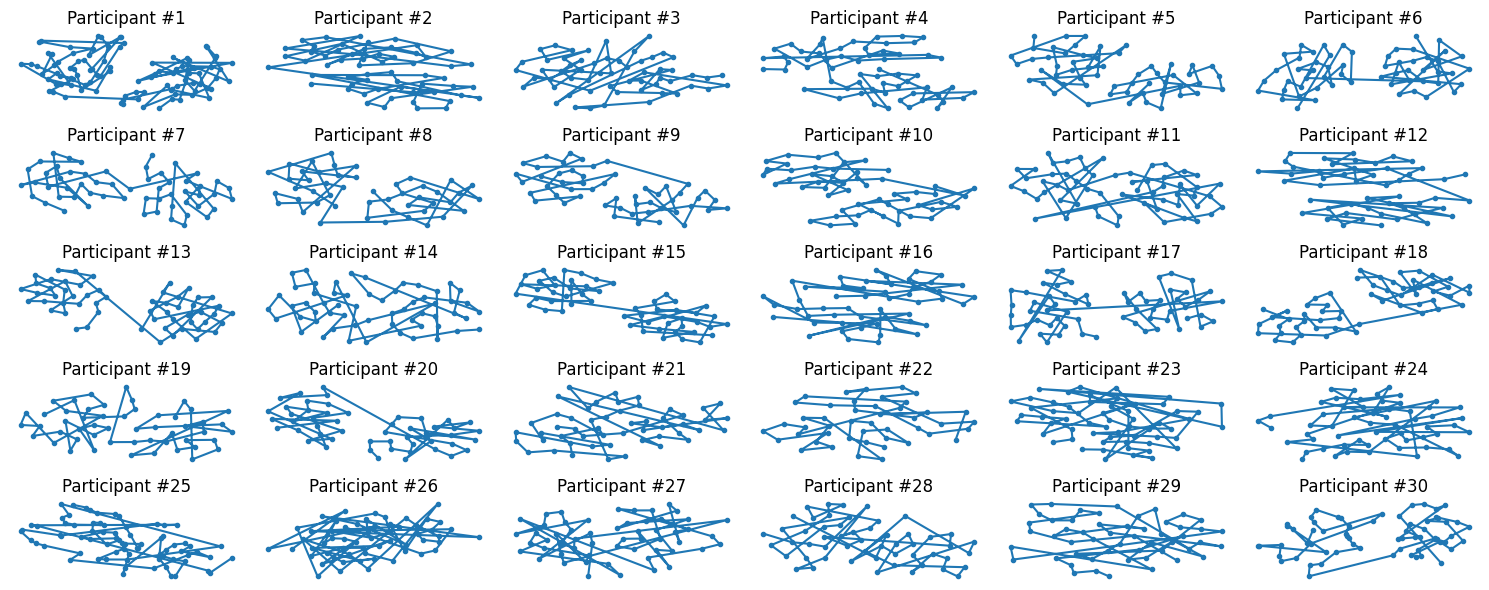

In [15]:
fig, axarr = plt.subplots(5, 6, figsize = (15, 6))

for person in range(0, 30):
    single_person = both_df[(label == 'WALKING') & (both_df['subject'] == '#{}'.format(person+1))].drop(['subject', 'Data'], axis = 1) # extract only 'WALKING data ex) #1, #2, #3,...

    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)

    # Reduce dimesnions
    pca = PCA(n_components=0.9, random_state = 3)
    tsne_data = pca.fit_transform(tsne_data)

    # Transform data
    tsne = TSNE(random_state = 3)
    tsne_transformed = tsne.fit_transform(tsne_data)

    # Create plot
    axarr[person // 6][person%6].plot(tsne_transformed[:, 0], tsne_transformed[:, 1], '.-') # person // 6: rpw, person % 6: column select (row, column)
    ## tsne=> tsne_transformed[:, 0]: x-axis, tsne_transformed[:, 1]: y-axis
    '''
    finally, t-SNE projects high-dimensional data onto a 2-dimensional plane while preserving the distances between data points--keeping the ones that are close together and those that are fat apart. This allows the originally high-dimensional (n-dimensional) data to be easily visualized.
    '''
    axarr[person // 6][person%6].set_title('Participant #{}'.format(person + 1))
    axarr[person // 6][person%6].axis('off')

plt.tight_layout()
plt.show()

The visialization assumes the data is time series. Two distinct clusters(ex: #1, #6, #7 ...) appear for each participant, suggesting each cluster represents a separate walking session rather than alternate steps. This insight emphasizes the importance of analyzing individual walking experiments for accurate classification.

Upon examining the time-series data, some participants'data appear to be divided into two distinct clusters. This division is likely due to participants conducting the experiment twice, which can only be confirmed by directly examining the data.

### How long does the particaipant walk?

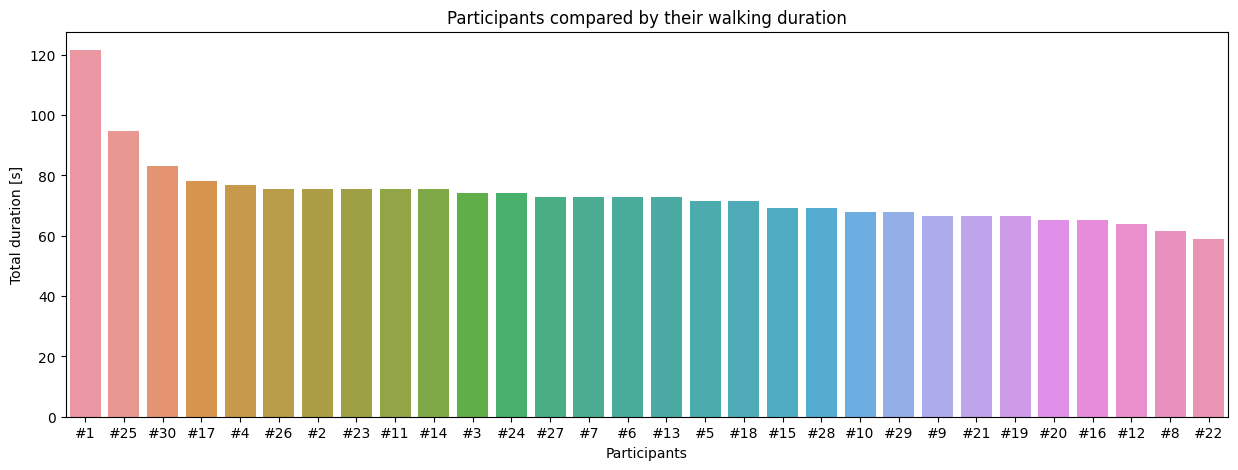

In [16]:
# group the data by participant and compute total duration of walking
mask = label == 'WALKING'
duration_df = (both_df[mask].groupby('subject')['Data'].count() * 1.28)

# create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending = False)

plt.figure(figsize = (15, 5))
sns.barplot(data = plot_data, x = 'subject', y = 'Data')
plt.title('Participants compared by their walking duration')
plt.xlabel('Participants')
plt.ylabel('Total duration [s]')
plt.show()

since the duration of each participant walking is distributed over a range I assume the participants had a fixed walking distance for their experiment rathe than a fixed duration.

### Is there a unique staircase walking style for each participant

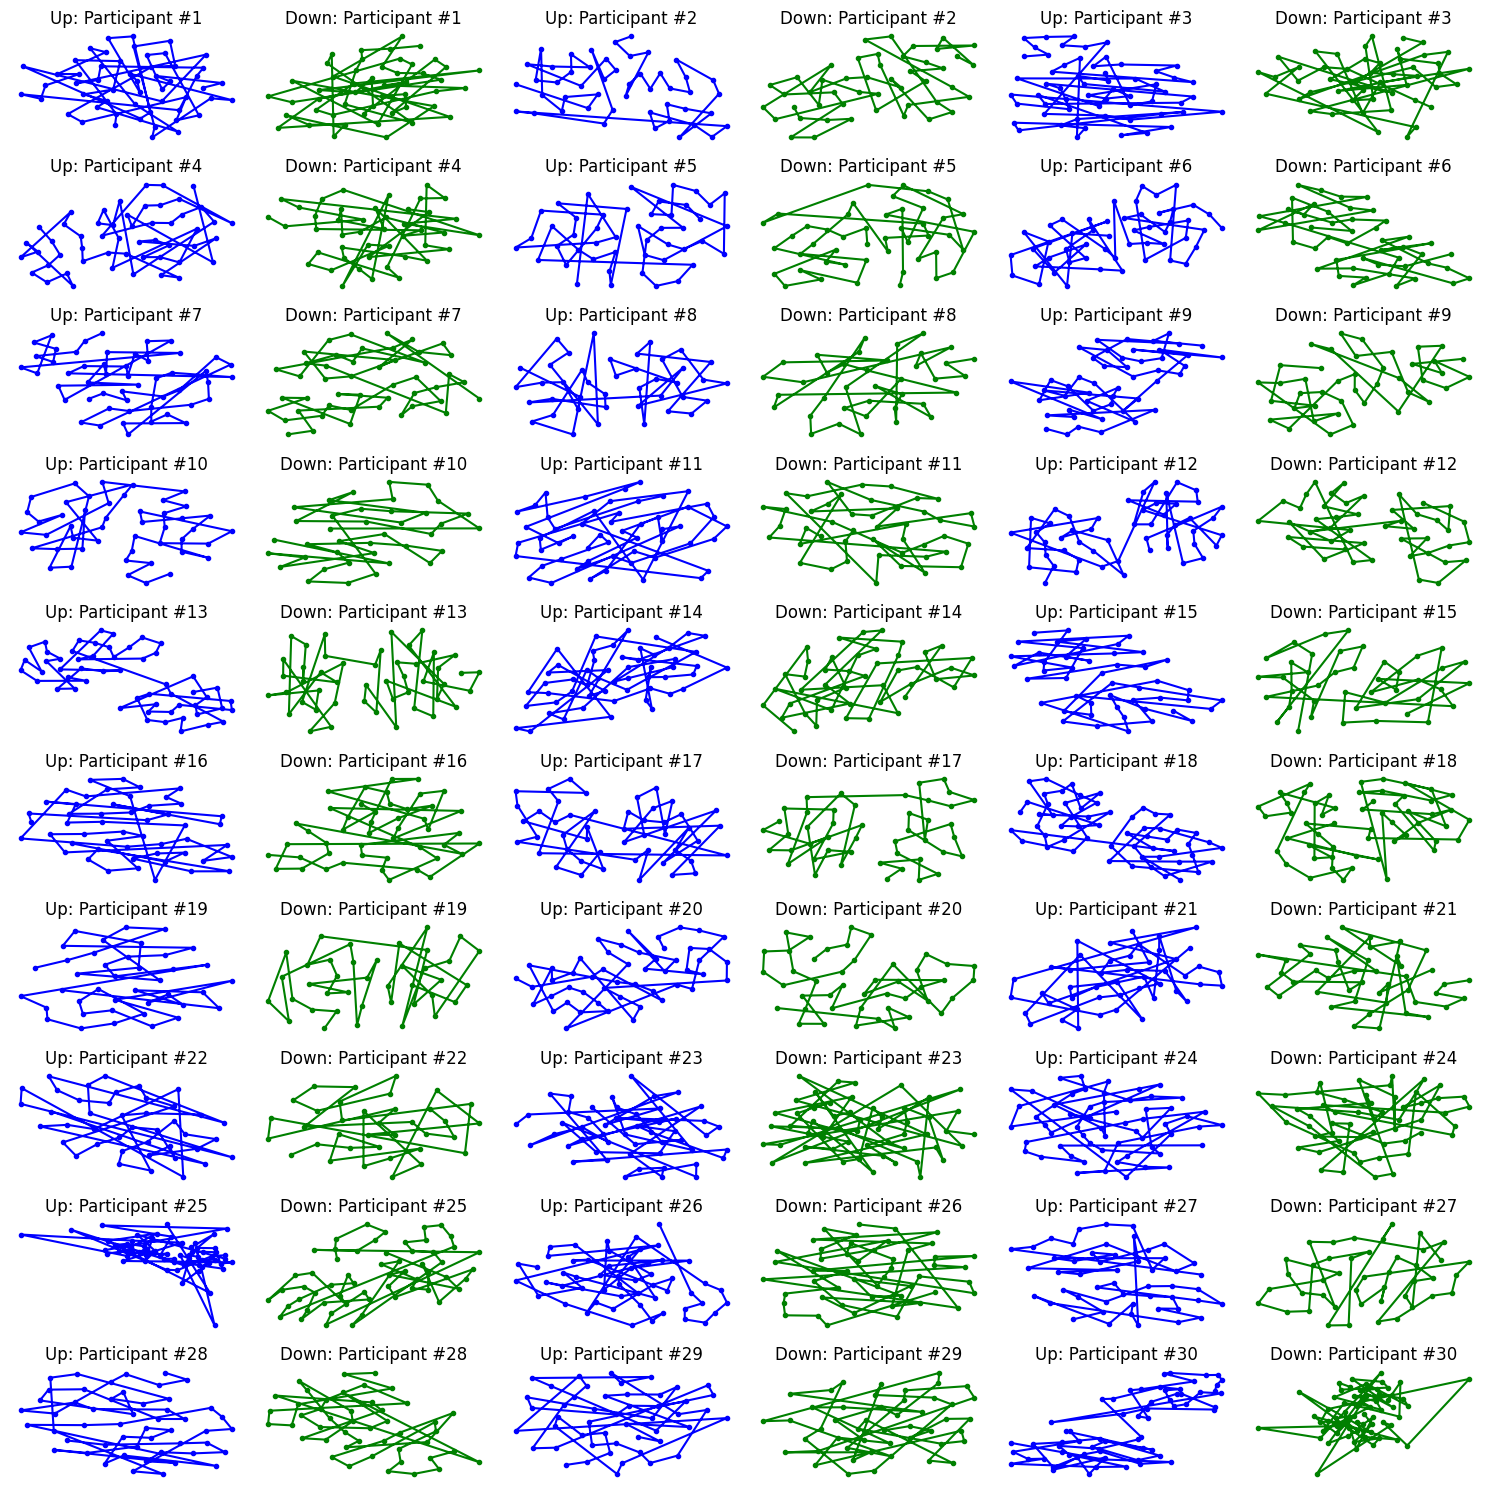

In [17]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = both_df[(label=='WALKING_UPSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = both_df[(label=='WALKING_DOWNSTAIRS') & (both_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)

    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)

    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()

In most of the plots a structure with two clusters is again recognizable. Going up and down the stairs for two times is likely for the experiment.

I will review the durations for this assumption with a small experiment on my stairs


## what is the walking frequency of a single participant
I could extract the main components of the walking style of the participants using only the eucliden norm of the three accelerometer axes.

First of all I combined both walking experiments (clusters) of a single participant and tried to decompose the components.

information about Singular-Spectrum Analysis notebook (SSA) by jdarcy(https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition)


#### Singular Spectrum Analysis (SSA) related to time series requires further study for complete function comprehension to me

In [18]:
# Use SS class fro jdarcy
class SSA(object):    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        '''
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        '''
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError('Unsupported time series object. Try Pandas Series, NumPy array or list.')
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError('The window length must be in the interval [2, N/2].')
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = 'Re-run with save_mem=False to retain the elementary matrices.'
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = 'Re-run with save_mem=False to retain the V matrix.'
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        '''
        Returns all the time series components in a single Pandas DataFrame object.
        '''
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ['F{}'.format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        '''
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        '''
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        '''
        Calculates the w-correlation matrix for the time series.
        '''
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        '''
        Plots the w-correlation matrix for the decomposed time series.
        '''
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r'$\tilde{F}_i$')
        plt.ylabel(r'$\tilde{F}_j$')
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label('$W_{i,j}$')
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

### #1 subject ssa analysis

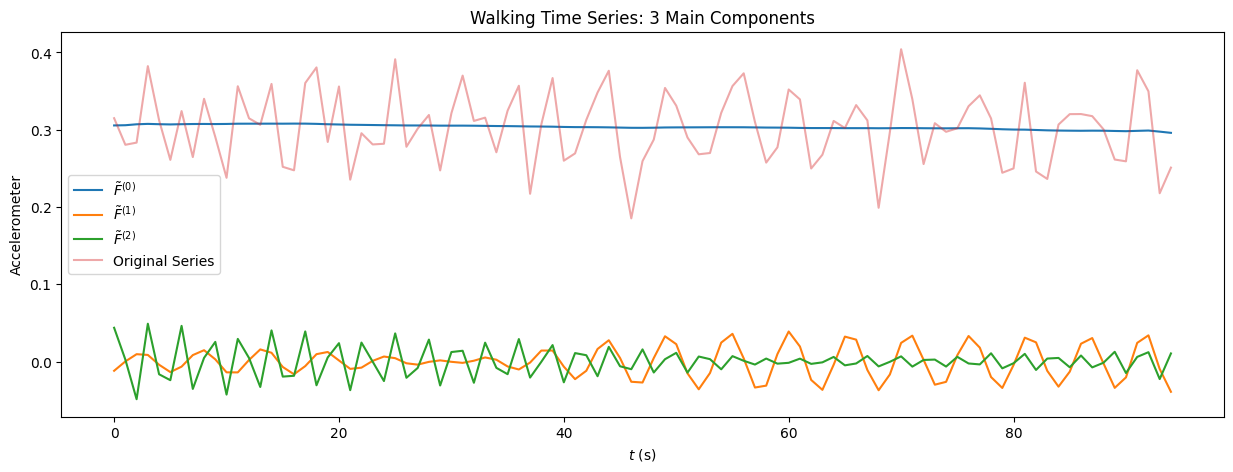

In [19]:
# Eucliden norm of the acceleration
## Eucliden norm: masure of vector magnituge or lengh in Eucliden space. It is calculated as the square root of the sum of the squared components of the vector.

# only the x, y, and z-axis data from the tBodyAcc series are extracted for analysis.
walking_series = both_df[(label =='WALKING') & (both_df['subject'] == '#1')][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True) 

# square(**2) each value, sum them, and take the square root(**0.5)
walking_series = (walking_series**2).sum(axis = 1)**0.5

# Decomposing the series
## The walking_series calculated above is embedded into an SSA(Singular Spectrum Alanysis) trajectory matrix using a window of size 30
## SSA involves embedding time-series data into a trajectory(궤적) martrix of length L, performing Singular Value Decomposition(SVD) on the matrix, and extracting the key components. 
##Each component represents the major patterns or variations in the time sereies.

series_ssa = SSA(walking_series, 30)


# plotting the decomposition
plt.figure(figsize = (15,5))
series_ssa.reconstruct(0).plot() # plot the first component. reconstructed from the origin time series
series_ssa.reconstruct([1,2]).plot() # plot the secon and third components
series_ssa.reconstruct([3,4]).plot()
series_ssa.orig_TS.plot(alpha = 0.4)
plt.title('Walking Time Series: 3 Main Components')
plt.xlabel(r'$t$ (s)')
plt.ylabel('Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
plt.legend(legend)

you can see the original data from the accelerometer can be decomposed into three main components. The first one (blue) reveals the overall constant trend.

The other two(yellow, green) represent the oscillationg walking frequencies.

The frequency change in the middle of the plot underlines the assumption of two distinct walking experiments.

Furthermore it can be stated that both experiments had different walking speeds (e.g walking and running)


### #4 subject ssa analysis

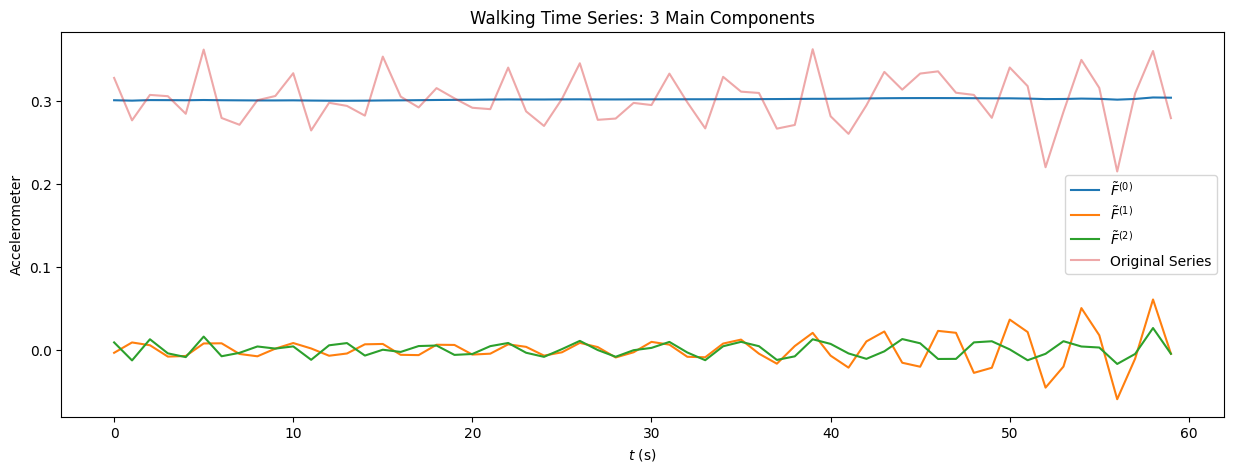

In [20]:
walking_series = both_df[(label =='WALKING') & (both_df['subject'] == '#4')][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True) 

walking_series = (walking_series**2).sum(axis = 1)**0.5

series_ssa = SSA(walking_series, 30)


# plotting the decomposition
plt.figure(figsize = (15,5))
series_ssa.reconstruct(0).plot() 
series_ssa.reconstruct([1,2]).plot() 
series_ssa.reconstruct([3,4]).plot()
series_ssa.orig_TS.plot(alpha = 0.4)
plt.title('Walking Time Series: 3 Main Components')
plt.xlabel(r'$t$ (s)')
plt.ylabel('Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(3)] + ['Original Series']
plt.legend(legend)

Finally, the current code(ssa) decomposes the time series into three main components using SSA. 

Based on these main componenets, you can analyze the time series for each subject to extract distinguishing features and better understand their walking patterns!

### what is the walking frequency of both found speeds?

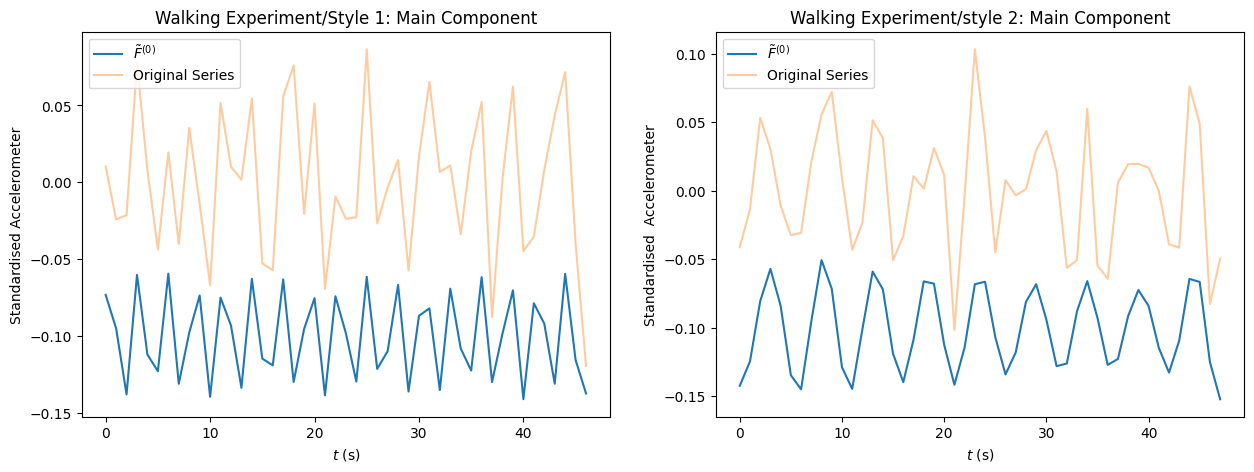

In [21]:
# both walking styles from a single participant
'''
By selecting rows 78:124 and 248: 295 using loc, we seperate the walking data into two distinct styles, as each activity was performed twice by the subject.
1. we extract the acceleration data along the x, y, and z axes, calculate the Eculidean norm to represent the overall movement intensity as a single value, 
and normalize the data by subtracting the mean.
2. we recnstruct the decomposed components isong the first principal component, which reveals the main trend and significant variationsin the original time series.
'''
style1 = both_df.loc[78:124][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop = True)
style1 = ((style1**2).sum(axis = 1)**0.5)
style1 -= style1.mean()
style2 = both_df.loc[248:295][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop = True)
style2 = (style2**2).sum(axis=1)**0.5
style2 -= style2.mean()

#Decompose
style1_ssa = SSA(style1, 20)
style2_ssa = SSA(style2, 20)

# create plot
fig, axarr = plt.subplots(1, 2, figsize = (15, 5))

# ploting the decomposition style 1
(style1_ssa.reconstruct([0, 1]) - 0.1).plot(ax = axarr[0])
style1_ssa.orig_TS.plot(alpha = 0.4, ax = axarr[0])
axarr[0].set_title('Walking Experiment/Style 1: Main Component')
axarr[0].set_xlabel(r'$t$ (s)')
axarr[0].set_ylabel('Standardised Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(1)] + ['Original Series']
axarr[0].legend(legend);

# ploting the decomposition style 2
(style2_ssa.reconstruct([0, 1]) - 0.1).plot(ax = axarr[1])
style2_ssa.orig_TS.plot(alpha = 0.4, ax = axarr[1])
axarr[1].set_title('Walking Experiment/style 2: Main Component')
axarr[1].set_xlabel(r'$t$ (s)')
axarr[1].set_ylabel('Standardised  Accelerometer')
legend = [r'$\tilde{{F}}^{{({0})}}$'.format(i) for i in range(1)] + ['Original Series']
axarr[1].legend(legend);

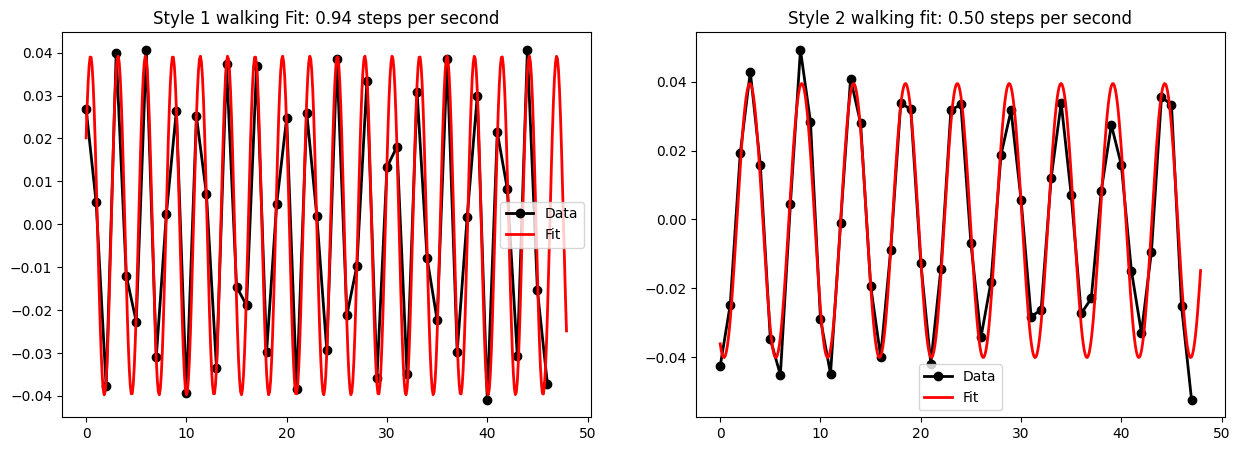

In [22]:
# Function to fit a sinus
## fittung Sinusoidal Curve function
'''
The original time series data measured by the accelerometer includes information such as overall walking, patterns, and noise variations.
However, the data fitted with a sine function perimarily reflects the periodic patterns fo the time series (walking frequency).
The simplified patterns exrtacted through SSA, based on the primary components, represent the major periodicity of the actual data in a simplified manner.

Purpose of analysis
1. Estimating walking frequency
- By fitting a sine function, the participant's walking frequency can be quantitatitvely measured. This provides crucial information for analyzing walking speed or patterns.
2. Comparing walking styles
- By comparing the walking frequencies of two different walking styles, differences in walking speed or patterns between experiments can be identified.
'''
def fit_sin(tt, yy):
    '''
    Fit sin to the input time sequence adn return fitting paratmers "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"
    '''
    tt = np.array(tt)
    yy = np.array(yy)
    
    # Assume uniform spacing
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))

    # Excluding the zero frequency 'peak'
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp= np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    # Sinus
    def sinfunc(t, A, w, p, c):
        return A * np.sin(w*t + p) + c
    
    # Fit sinus
    popt, pcov = curve_fit(sinfunc, tt, yy, p0 = guess)
    A, w, p, c = popt
    f = w/(2.*pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "frq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess, popt, pcov)}

# Get data
main_style1 = style1_ssa.reconstruct([0, 1])
tt1 = main_style1.index
yy1 = main_style1.values
tt_res1 = np.arange(0, 48, 0.1)

#Fit data
res1 = fit_sin(tt1, yy1)

# Get data
main_style2 = style2_ssa.reconstruct([0, 1])
tt2 = main_style2.index
yy2 = main_style2.values
tt_res2 = np.arange(0, 48, 0.1)

# Fit data
res2 = fit_sin(tt2, yy2)

# plot data
fig, axarr = plt.subplots(1, 2, figsize = (15, 5))

# plot data
axarr[0].plot(tt1, yy1, "-ok", label = 'Data', linewidth = 2)
axarr[0].plot(tt_res1, res1['fitfunc'](tt_res1), "r-", label = 'Fit', linewidth = 2)
axarr[0].set_title('Style 1 walking Fit: {:.2f} steps per second'.format((res1['omega']*1.28)/(pi)))
axarr[0].legend(loc='best')

axarr[1].plot(tt2, yy2, "-ok", label = 'Data', linewidth = 2)
axarr[1].plot(tt_res2, res2['fitfunc'](tt_res2), "r-", label = 'Fit', linewidth = 2)
axarr[1].set_title('Style 2 walking fit: {:.2f} steps per second'.format((res2['omega']*1.28)/pi))
axarr[1].legend(loc = 'best')
plt.show()


Fitting a sinus curve to the main component of the walking experiments of participant #1 reveals the computed speed of both experients differed by a factor of nearly 2.

Since the second speed is suspiciously low there could be a sampling problem and information could habe been irrevocably lost while aggregating the dataset.

Potentially the datapoints are to wide spread to reconstruct the underlying frequency in a correct way.


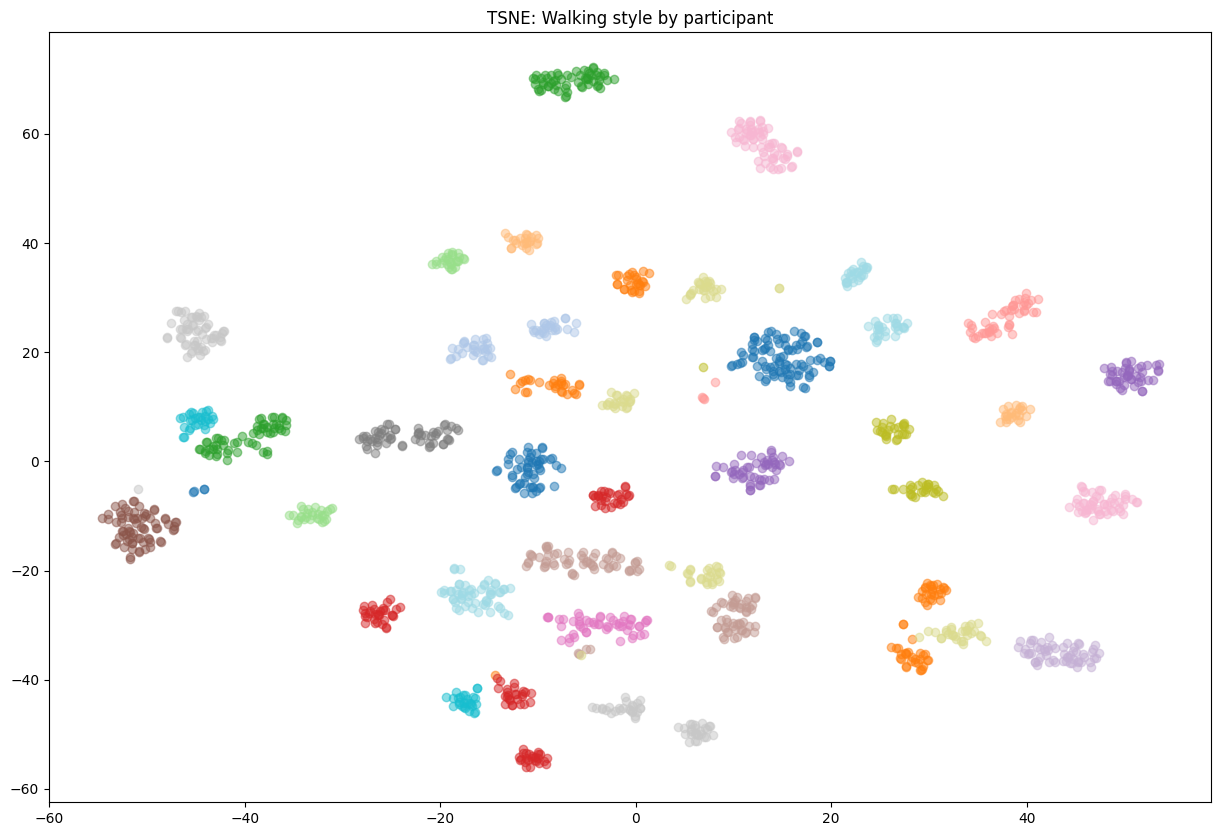

In [23]:
# get data
tsne_data = both_df[label == 'WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduece dimensions
pca = PCA(n_components = 0.9, random_state = 3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state = 3)
tsne_transformed = tsne.fit_transform(tsne_data)

# Create sybplots
fig, axarr = plt.subplots(1, 1, figsize = (15, 10))

### plot subject
# get colors
n = subject_data.unique().shape[0]
colormap = matplotlib.colormaps['tab20']
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(subject_data.unique()):
    mask = (subject_data == group).values
    axarr.scatter(x= tsne_transformed[mask][:, 0], y = tsne_transformed[mask][:, 1], c = colors[i], alpha = 0.5, label = group)

axarr.set_title('TSNE: Walking style by participant')
plt.show()


For the decomposition I have only shown a single participant with the two walking styles. By computing a t-SNE visualization of the walking of all participants you can see two clusters for each participant (Some more distinct than others).

Therefore the option of splitting the styles by decomposition suggets itself.

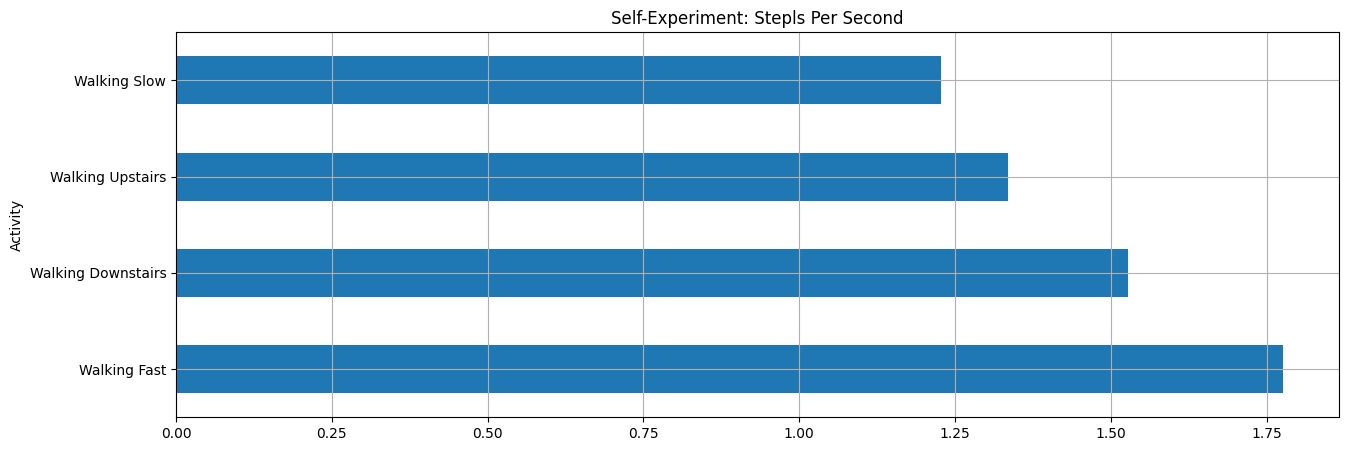

In [28]:
data = [['Walking Downstairs', 8.82, 15], 
        ['Walking Downstairs', 9.49, 15], 
        ['Walking Downstairs', 10.06, 15], 
        ['Walking Downstairs', 8.77, 15], 
        ['Walking Fast', 42.25, 80], 
        ['Walking Slow', 62.64, 80], 
        ['Walking Upstairs', 11.16, 15], 
        ['Walking Upstairs', 12.06, 15], 
        ['Walking Upstairs', 11.08, 15], 
        ['Walking Upstairs', 11.12, 15], 
        ['Walking Upstairs', 42.47, 60],
        ['Walking Downstairs', 10.334, 15],
        ['Walking Downstairs', 10.785, 15],
        ['Walking Downstairs', 10.487, 15],
        ['Walking Slow', 165.449, 200],
        ['Walking Fast', 115.360, 200],
        ['Walking Upstairs', 11.823, 15],
        ['Walking Upstairs', 11.872, 15],
        ['Walking Upstairs', 11.928, 15],
        ['Walking Upstairs', 11.351, 15]]

df = pd.DataFrame(data, columns = ['Activity', 'Duration', 'Steps'])
activity_df = df.groupby('Activity').sum()
activity_df['Frequency'] = activity_df['Steps'] / activity_df['Duration']
activity_df.sort_values('Frequency', ascending = False)['Frequency'].plot(kind = 'barh', grid = True, figsize = (15, 5))]
plt.title('Self-Experiment: Stepls Per Second')
plt.show()


The dataset exhibits significant variability, with considerable differences observed within the same activity data. Despite these challenges, the study achived an impressive 95% accuracy in distinguishing between 6 activities within a remarkably short 1-1.5 minute timeframe. By expanding data collection and leveraging comprehensive smartwatch sensor data - like, smartwatch is worn throughout an entire day - it is anticipated that even more personalized and high-precision models could be developed, capturng a more nuanced and complete picture of individual activities and physiological responses.